# Sales Forecasting Project: Retail Dataset

This notebook analyzes retail sales data to forecast future sales and revenue.

**Goals:**
- Load and explore retail datasets
- Merge orders, products, and customers data
- Check for missing values and data types
- Calculate revenue for each order
- Aggregate sales for modeling
- Build predictive ML models
- Visualize trends and predictions


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb


In [2]:
sales = pd.read_csv(r"C:\Users\cp055\Downloads\archive (1)\sales.csv")
features = pd.read_csv(r"C:\Users\cp055\Downloads\archive (1)\features.csv")
stores = pd.read_csv(r"C:\Users\cp055\Downloads\archive (1)\stores.csv")


display(sales.head())
display(features.head())
display(stores.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
print("Sales columns:", sales.columns.tolist())
print("Features columns:", features.columns.tolist())
print("Stores columns:", stores.columns.tolist())

sales.columns = sales.columns.str.strip().str.lower()
features.columns = features.columns.str.strip().str.lower()
stores.columns = stores.columns.str.strip().str.lower()

print(sales.columns)
print(features.columns)
print(stores.columns)

Sales columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Features columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
Stores columns: ['Store', 'Type', 'Size']
Index(['store', 'dept', 'date', 'weekly_sales', 'isholiday'], dtype='object')
Index(['store', 'date', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment',
       'isholiday'],
      dtype='object')
Index(['store', 'type', 'size'], dtype='object')


In [4]:
df = sales.merge(features, on=['store','date'], how='left')
df = df.merge(stores, on='store', how='left')

display(df.head())

,store,dept,date,weekly_sales,isholiday_x,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,isholiday_y,type,size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
df['is_holiday'] = df['isholiday_x']

df.drop(['isholiday_x', 'isholiday_y'], axis=1, inplace=True)

df['is_holiday'] = df['is_holiday'].astype(int)

print(df[['is_holiday']].head())

   is_holiday
0           0
1           1
2           0
3           0
4           0


In [6]:
for col in ['markdown_1','markdown_2','markdown_3','markdown_4','markdown_5']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

for col in ['CPI','unemployment']:
    if col in df.columns:
           df[col] = df[col].ffill() 


df['is_holiday'] = df['is_holiday'].astype(int)

df.isnull().sum()

store                0
dept                 0
date                 0
weekly_sales         0
temperature          0
fuel_price           0
markdown1       270889
markdown2       310322
markdown3       284479
markdown4       286603
markdown5       270138
cpi                  0
unemployment         0
type                 0
size                 0
is_holiday           0
dtype: int64

In [7]:
df_agg = df.groupby(
    ['store', 'dept', 'date', 'is_holiday', 'type', 'size'], 
    as_index=False
)['weekly_sales'].sum()

df_agg['date'] = pd.to_datetime(df_agg['date'], dayfirst=True, errors='coerce')

df_agg['week'] = df_agg['date'].dt.isocalendar().week
df_agg['month'] = df_agg['date'].dt.month
df_agg['year'] = df_agg['date'].dt.year
df_agg['day_of_week'] = df_agg['date'].dt.weekday  

In [8]:
df_agg = pd.get_dummies(df_agg, columns=['store', 'dept'], drop_first=True)

In [9]:
X = df_agg.drop(['weekly_sales', 'date'], axis=1)
y = df_agg['weekly_sales']

split = int(len(df_agg) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
df_encoded = pd.get_dummies(df_agg, columns=['type', 'is_holiday'], drop_first=True)

X = df_encoded.drop(['weekly_sales', 'date'], axis=1)
y = df_encoded['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

xg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xg.fit(X_train, y_train)
y_pred_xgb = xg.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))

NameError: name 'train_test_split' is not defined

In [ ]:
xg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xg.fit(X_train, y_train)
y_pred_xgb = xg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse)
print("XGBoost MAE:", mae)

XGBoost RMSE: 6114.976202805732
XGBoost MAE: 3516.306253090633


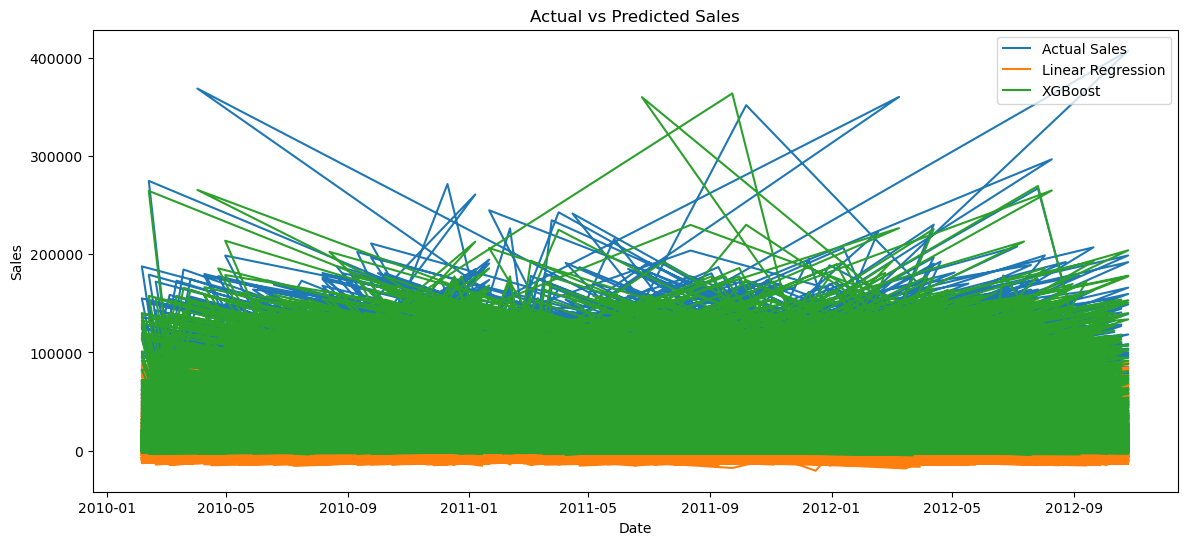

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_agg['date'][split:], y_test.values, label='Actual Sales')
plt.plot(df_agg['date'][split:], y_pred_lr, label='Linear Regression')
plt.plot(df_agg['date'][split:], y_pred_xgb, label='XGBoost')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()